# Part 4: Let's make binary classifiers!
<i style="font-size: 0.94em">This notebook is part of a series detailing the creation of models for predicting NFL game outcomes. For the table of contents listing all notebooks in the series, <a href="0.Introduction_NFL_Prediction.ipynb">click here.</a></i>

To start with, we'll read in the data frame built in the last notebook. If you recall, it represented each game as an average of game statistics for each team, calculated up to but not including the game in consideration. This represented the information publically available before the game in consideration began. The stat vectors of summarized stats per team were concatenated to build the training inputs for each game.

After reading in the data, we'll need binary class labels for our games. A negative point differential means that "our" team lost, and a positive one means "our" team won. We'll go ahead and count the few draws that occur in the NFL as losses. 

After making the binary class labels, we'll normalize the data, split it, and input it into a variety of models from SciKitLearn. I'll make this process even easier by defining a convenience method that I can use to smoothly create and run a variety of models.

The cell below sets everything up; beyond that, we can run a variety of slightly different data sets and models to see what comes out!

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

directory = "./Data/"
input_file_name = "labeled_data.pkl"
labeled_data_df = pd.read_pickle(directory+input_file_name)
labeled_data_df["gold_label_binary"] = labeled_data_df["gold_label"].apply(lambda x : 0.0 if x < 0.0 else 1.0)

def sklearn_helper(classifier, split_data, verbose=True):
    train_data = split_data[0]
    test_data = split_data[1]
    train_labels = split_data[2]
    test_labels = split_data[3]
    classifier.fit(train_data, train_labels)
    accuracy = classifier.score(test_data, test_labels)
    if verbose:
        print(f"Accuracy of {classifier}: {accuracy}")
    return accuracy

def run_tests(split_data):
    sklearn_helper(LogisticRegression(random_state=0, max_iter=100000), split_data)
    sklearn_helper(SVC(random_state=0, kernel='rbf'), split_data)
    sklearn_helper(GaussianNB(), split_data)
    sklearn_helper(KNeighborsClassifier(n_neighbors=17), split_data)
    sklearn_helper(GradientBoostingClassifier(), split_data)
    sklearn_helper(RandomForestClassifier(n_estimators=1000, random_state=0), split_data)

# Scale the features, get labels, and do train/test split
def get_split_data(df):
    labels = df["gold_label_binary"]
    features = df.loc[:, "is_home_team":"season_games_to_now_them"]
    features = StandardScaler().fit_transform(features)
    return train_test_split(features, labels, test_size=0.15, random_state=0)

## Experiment 1: A variety of models with default parameters and all games from 2009-2018 included

In [2]:
split_data = get_split_data(labeled_data_df)
run_tests(split_data)

Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.633245382585752
Accuracy of SVC(random_state=0): 0.6253298153034301
Accuracy of GaussianNB(): 0.6292875989445911
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.6451187335092349
Accuracy of GradientBoostingClassifier(): 0.6569920844327177
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.6437994722955145


## Experiment 2: Let's not bet on the first two games of the season
This uses the results of the first two games of each season to calculate the 'up-to-now' statistics used in prediction, but does not use results of these games to train or test. This is the equivalent of just accepting we know nothing at the start of the season and then letting the first two games play out before making any picks or bets.

In [4]:
exp_2_df = labeled_data_df[labeled_data_df["season_games_to_now_us"] > 1]    
split_data = get_split_data(exp_2_df)
run_tests(split_data)

Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.6661631419939577
Accuracy of SVC(random_state=0): 0.6510574018126888
Accuracy of GaussianNB(): 0.6646525679758308
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.6782477341389728
Accuracy of GradientBoostingClassifier(): 0.6782477341389728
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.6706948640483383


## September games can poorly reflect the rest of the season. Why not skip those as well?

In [5]:
exp_3_df = labeled_data_df[labeled_data_df["season_games_to_now_us"] > 3]    
split_data = get_split_data(exp_3_df)
run_tests(split_data)

Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.6554770318021201
Accuracy of SVC(random_state=0): 0.6448763250883393
Accuracy of GaussianNB(): 0.6413427561837456
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.6448763250883393
Accuracy of GradientBoostingClassifier(): 0.6554770318021201
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.6183745583038869


## Which of the above works best?
In general, the data set that excludes the first two games of each season looks most promising. Why might this be the case? The first game of a season is a big guessing game. Most teams change significantly from season to season, in terms of both their roster and their coach. Hence, statistics from the prior season (which is how the first game of each season's statistics got filled in) do not really reflect the team's current iteration. Two gamse allows for ample time to learn how good this team is likely to be and then start to predict.

However, the data set that excluded the first four games does not generally perform as well as the one excluding two. How can this be possible? Don't we have more information on how good each team really is by that point? Yes, but we lose a large number of data points that might be used for training. The larger data set available for training in the all-but-first-two-games model more than makes up for the additional confidence we can have about each team's calculated stats in the latter model.

Having said that, the model still performed fairly well on the data set including every single game, so perhaps it is not worth skipping a bet or prediction for the season-opening games!

# Would a smaller representation work better?
As indicated in the notebook preceding this one, the dataset for the NFL model is quite small. A smaller data set with so many dimensions (close to 100) could lead to overfitting. We can try out a smaller representation with fewer dimensions to see if it results in comparable performance before moving on to hyperparameter tuning for the GradientBoostingClassifier, Random Forest, and K Nearest Neighbors, the algorithms above which performed best.
## Which dimensions matter most?
The random forest model can help us answer this question. It stands out among other machine learning models in being easy to interpret and use. By printing out the feature importances gathered by the random forest model, it's easy to see which dimensions may be worth dropping.

This can be calculated in two ways, impurity-based and permutation importance. Why not examine both?

In [10]:
# Get the labels and scale the features
feature_descriptors = labeled_data_df.loc[:, "is_home_team":"season_games_to_now_them"].columns
train_data, test_data, train_labels, test_labels = get_split_data(labeled_data_df)

rf_class = RandomForestClassifier(n_estimators=100, random_state=0)
rf_class.fit(train_data, train_labels)
accuracy = rf_class.score(test_data, test_labels)
print(f"Accuracy of random forest: {accuracy}")
feature_importance = pd.Series(rf_class.feature_importances_, index=feature_descriptors)
print("Impurity-based importances")
print(feature_importance)

permu_importance = permutation_importance(rf_class, 
                                                test_data, 
                                                test_labels, 
                                                n_repeats=5, 
                                                random_state=0, 
                                                n_jobs=5)
print("\nPermutation Importances")
permu_importance = pd.Series(permu_importance.importances_mean, index=feature_descriptors)
print(permu_importance)

Accuracy of random forest: 0.6411609498680739
Impurity-based importances
is_home_team                0.009583
point_dif_us                0.025290
off_drives_us               0.008934
off_total_start_pos_us      0.015026
completed_passes_us         0.010068
                              ...   
hit_their_qb_them           0.009913
sacked_their_qb_them        0.009725
sack_yards_them             0.010336
tackles_for_loss_them       0.010319
season_games_to_now_them    0.006564
Length: 95, dtype: float64

Permutation Importances
is_home_team                0.024011
point_dif_us                0.006596
off_drives_us              -0.001319
off_total_start_pos_us      0.003166
completed_passes_us        -0.003166
                              ...   
hit_their_qb_them           0.003958
sacked_their_qb_them        0.000264
sack_yards_them             0.012137
tackles_for_loss_them       0.002111
season_games_to_now_them   -0.000528
Length: 95, dtype: float64


## Well that doesn't match up...
The importances calculated above do not corroborate each other at all. What can we do? As a quick solution, l
let's simply add them up and then sort the result to see which one's have a low score in both models (resulting in a low sum). Then, we can toss these unimportant features out and try training more models!

In [11]:
overall_importance = (feature_importance + permu_importance) \
                    .sort_values(ascending=False)
pd.set_option("display.max_rows", None)
print(overall_importance)

point_dif_them               0.047071
is_home_team                 0.033593
point_dif_us                 0.031886
sack_yards_them              0.022473
time_possession_us           0.020192
first_downs_earned_us        0.019790
interceptions_thrown_us      0.019184
off_total_start_pos_them     0.018204
off_total_start_pos_us       0.018192
passes_attempted_us          0.017800
r_yards_allowed_us           0.016488
r_yards_allowed_them         0.016438
interceptions_caught_us      0.016252
net_passing_yards_them       0.015845
first_downs_allowed_them     0.015692
rush_td_allowed_them         0.015676
fg_made_them                 0.015487
off_pen_yards_them           0.015374
num_def_plays_us             0.015273
forced_fumbles_us            0.014851
yards_after_catch_us         0.014739
first_downs_earned_them      0.014500
opp_fg_attempt_yards_them    0.014441
pass_td_allowed_them         0.014408
times_sacked_us              0.014301
passes_attempted_them        0.014257
first_downs_

# Analysis
The stats at the top of the importances list line up well with common wisdom about football. Point differentials, sacks, time of possession, and being the home team all make a big impact, at least relative to the other stats. 

However, the bottom of the list has a few surprises. It is odd to see rushing touchdowns so close to the bottom of the list. Less surprising are interceptions resulting in a touchdown, known as pick-sixes. These are an uncommon event and thus do not make much impact. 

# Trying out reduced representations
We'll do two simple tests on the above to see whether reduced representations of the game data perform decently well. If they come close to the higher-dimensional representations, they may be worth tuning and will likely predict real-world occurrences better than higher-dimensional representations (due to less likelihood of overfitting).

First, we'll take only the top ten most important stats and see how well these alone can predict games. Then, the top twenty and the top fifty. How much predictive value can only ten numbers in a game as complex as football really have? We're about to see...


In [7]:
items_to_drop = overall_importance.index[10:]

topN_df = labeled_data_df.drop(items_to_drop, axis=1)

# Get the labels and scale the features
labels = topN_df["gold_label_binary"]
features = topN_df.loc[:, "is_home_team":"passes_attempted_us"]
features = StandardScaler().fit_transform(features)
split_data = train_test_split(features, labels, test_size=0.15, random_state=0)
print("Models trained using only the top 10 features")
run_tests(split_data)

Models trained using only the top 10 features
Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.58311345646438
Accuracy of SVC(random_state=0): 0.5910290237467019
Accuracy of GaussianNB(): 0.5976253298153035
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.5672823218997362
Accuracy of GradientBoostingClassifier(): 0.5870712401055409
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.554089709762533


In [12]:
items_to_drop = overall_importance.index[20:]

topN_df = labeled_data_df.drop(items_to_drop, axis=1)

# Get the labels and scale the features
labels = topN_df["gold_label_binary"]
features = topN_df.loc[:, "is_home_team":"forced_fumbles_us"]
features = StandardScaler().fit_transform(features)
split_data = train_test_split(features, labels, test_size=0.15, random_state=0)
print("Models trained using only the top 20 features")
run_tests(split_data)

Models trained using only the top 20 features
Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.5923482849604221
Accuracy of SVC(random_state=0): 0.6055408970976254
Accuracy of GaussianNB(): 0.5976253298153035
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.5897097625329816
Accuracy of GradientBoostingClassifier(): 0.6015831134564644
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.5672823218997362


In [13]:
items_to_drop = overall_importance.index[50:]
topN_df = labeled_data_df.drop(items_to_drop, axis=1)

# Get the labels and scale the features
labels = topN_df["gold_label_binary"]
features = topN_df.loc[:, "is_home_team":"opp_fg_attempts_them"]
features = StandardScaler().fit_transform(features)
split_data = train_test_split(features, labels, test_size=0.15, random_state=0)
print("Models trained using only the top 50 features")
run_tests(split_data)

Models trained using only the top 50 features
Accuracy of LogisticRegression(max_iter=100000, random_state=0): 0.6451187335092349
Accuracy of SVC(random_state=0): 0.6385224274406333
Accuracy of GaussianNB(): 0.6437994722955145
Accuracy of KNeighborsClassifier(n_neighbors=17): 0.6134564643799473
Accuracy of GradientBoostingClassifier(): 0.6411609498680739
Accuracy of RandomForestClassifier(n_estimators=1000, random_state=0): 0.6543535620052771


# Analysis
The performance of the 50-dimensional representation is comparable to that of of the larger, 95-dimensional representation. However, the 10 and 20 dimensional feature sets perform poorly. Football is a complex game, and a simple representation cannot fully predict winners with any real accuracy. To find the true "sweet spot" for number of dimensions and which dimensions exactly to omit, significantly more testing would be necessary.

Even given the decent performance of the 50-dimensional feature set, it must be said that the feature importances discerned by the RF analysis are rather puzzling. How can the number of completed passes rank so low? How can the number of rushing TDs we allow the opponent to score be the second-worst statistic? Perhaps the importance metric calculated does not properly reflect the real importances.

Given that the data set is small enough, perhaps it is smartest to keep all the features for now.

# Tuning the RF model for maximum performance
To get the most out of the RF model, we can adjust the hyperparameters. While manually tweaking the hyperparameters and watching the results come out is quite fun, it's not really efficient and is not likely to result in a near-optimum solution (getting an true-optimum set of hyperparameters is NP-hard and impractical).

A straightforward approach here is to use a randomized grid search. SciKit learn provides an immensely convenient way to to this. We'll exclude the first two games of each season, as this gets slightly better results and will speed up the code. Not betting on the first two games of the season, after all, is a reasonable precaution to take.

<i><b>NOTE: With reasonable values of n_iter and cv (such as 400 and 8), the code below takes hours to run. It is mostly here just for reference. If you want to run it within ten minutes or so, set n_iter to something like 5 or 10, but of course this will greatly reduce the likelihood of finding good parameters.</b></i>

In [10]:
from numpy import linspace

exclude_2_df = labeled_data_df[labeled_data_df["season_games_to_now_us"] > 1]  

labels = exclude_2_df["gold_label_binary"]
features = exclude_2_df.loc[:, "is_home_team":"season_games_to_now_them"]
features = StandardScaler().fit_transform(features)
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.15, random_state=0)

# Define hyperparameter possibilities
n_estimators = [int(x) for x in linspace(start=400, stop=2000, num=17)]
max_features = ["sqrt", "log2"]
max_depth = [int(x) for x in linspace(start=5, stop=50, num=25)]
min_split = [int(x) for x in linspace(start=2, stop=20, num=10)]
min_leaf = [int(x) for x in linspace(start=1, stop=21, num=11)]
bootstrap = [True, False]
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_split,
                       'min_samples_leaf': min_leaf,
                       'bootstrap': bootstrap}
rf_optimized = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                  param_distributions=hyperparameter_grid, 
                                  n_iter=300,
                                  cv=6, 
                                  verbose=0,
                                  random_state=0, 
                                  n_jobs=-1)
rf_optimized.fit(train_data, train_labels)
print(rf_optimized.best_params_)
best_rf = rf_optimized.best_estimator_
accuracy = best_rf.score(test_data, test_labels)
print(f"Accuracy of best rf: {accuracy}")

{'n_estimators': 1000, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 16, 'bootstrap': False}
Accuracy of best rf: 0.6661631419939577


# What about the KNN model?
Astute readers may have noticed that the KNN model in the earlier analyses comparing all the different models performed quite well. While KNN is considered a somewhat basic and even 'dumb' model, it can sometimes perform well. It is a lazy learner, which means it basically does not need training and thus can run quite fast. 

Can we squeeze any more performance out of the KNN model? Let's see...

KNN has fewer hyperparameters to play with than the random forest. The most obvious one to tune is K itself. By running a simple for-loop, recording the accuracy, and making a graph, we can clearly see which value of K will perform best.


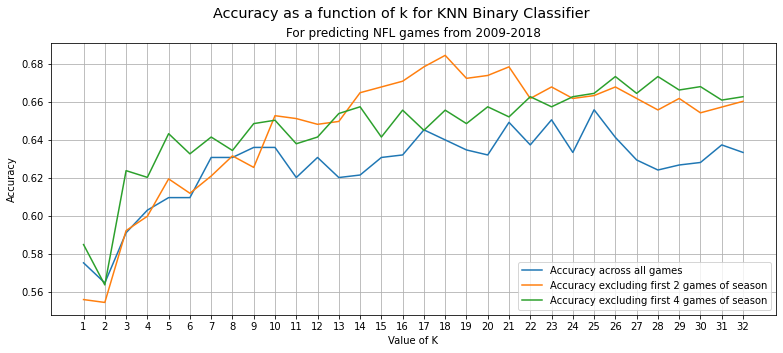

In [15]:
import matplotlib.pyplot as plt

exclude_2_df = labeled_data_df[labeled_data_df["season_games_to_now_us"] > 1]  
split_data_exclude_2 = get_split_data(exclude_2_df)

exclude_4_df = labeled_data_df[labeled_data_df["season_games_to_now_us"] > 3]  
split_data_exclude_4 = get_split_data(exclude_4_df)
 
split_data_all = get_split_data(labeled_data_df)

results_all_games = []
results_exclude_2 = []
results_exclude_4 = []
for k in range(1, 33):
    results_exclude_2.append(
        sklearn_helper(KNeighborsClassifier(n_neighbors=k), split_data_exclude_2, verbose=False))
    results_exclude_4.append(
        sklearn_helper(KNeighborsClassifier(n_neighbors=k), split_data_exclude_4, verbose=False))
    results_all_games.append(
        sklearn_helper(KNeighborsClassifier(n_neighbors=k), split_data_all, verbose=False))
    

plt.figure(figsize=(13, 5))
plt.plot(range(1, 33), results_all_games)
plt.plot(range(1, 33), results_exclude_2)
plt.plot(range(1, 33), results_exclude_4)
plt.suptitle("Accuracy as a function of k for KNN Binary Classifier", size="x-large")
plt.title("For predicting NFL games from 2009-2018", size="large")
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.xticks(range(1, 33))
plt.grid()
legend_labels = ["Accuracy across all games", 
                 "Accuracy excluding first 2 games of season", 
                 "Accuracy excluding first 4 games of season"] 
plt.legend(legend_labels, loc="lower right")
plt.show()

## Analysis of KNN performance
The graph above makes clear that the best overall performance came from excluding the first two games of each season and using a k-value generally between 16 and 21. When considering all games for the season, k-values of 25, 23, 21, and 17 performed best. Removing the first four games of each season to gather more data, rather than only removing the first two, does not seem worthwhile, as it performs generally worse and predicts fewer games overall

However, the above results came without performing cross-validation. Redoing the experiment with the inclusion of cross-validation would make the results more reliable.